**Logeswar BS AI-Assignment **

In [ ]:
import zipfile
import os

zip_path = "/content/Dataset.zip"  # Replace with your file name
extract_path = "/content"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted at:", extract_path)


Extracted at: /content


***Dataset Preparation ***

The dataset consists of medical images categorized into seven disease classes:

AD, CN, EMCI, LMCI, MCI, Normal, and Tumor.

The dataset is organized into:

train/: Subfolders for each class containing labeled images.

test/: Images used for evaluating the model’s performance.

**Data Preprocessing**

To prepare the data for training:

All images are resized to 224×224 pixels.

Data augmentation is applied to the training set to improve generalization:

Random horizontal flipping

Random rotation

Pixel values are normalized using ImageNet statistics:

Mean: [0.485, 0.456, 0.406]

Std Dev: [0.229, 0.224, 0.225]

**Training**

Loss Function: Cross-Entropy Loss

Optimizer: Adam optimizer (learning rate = 1e-4)

Epochs: 10

The model is trained on the training set using mini-batch gradient descent (batch_size = 32).

Model learns to minimize classification error across classes.


In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
train_dir = "/content/Dataset/train"
test_dir = "/content/Dataset/train"

# Transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

# Datasets and loaders
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Load EfficientNet-B0
model = models.efficientnet_b0(pretrained=True)

# Replace the classifier head
num_classes = len(train_dataset.classes)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 96.8MB/s]


Epoch 1/10, Loss: 1.4121
Epoch 2/10, Loss: 0.7529
Epoch 3/10, Loss: 0.5577
Epoch 4/10, Loss: 0.4712
Epoch 5/10, Loss: 0.4063
Epoch 6/10, Loss: 0.3771
Epoch 7/10, Loss: 0.3226
Epoch 8/10, Loss: 0.2636
Epoch 9/10, Loss: 0.2399
Epoch 10/10, Loss: 0.1791

Classification Report:
              precision    recall  f1-score   support

          AD       1.00      1.00      1.00       205
          CN       0.95      1.00      0.97       205
        EMCI       1.00      0.96      0.98       240
        LMCI       0.96      0.99      0.97        72
         MCI       0.99      0.98      0.98       210
      Normal       1.00      1.00      1.00       215
       Tumor       1.00      1.00      1.00       225

    accuracy                           0.99      1372
   macro avg       0.98      0.99      0.99      1372
weighted avg       0.99      0.99      0.99      1372



**Model Selection: EfficientNet-B0**

We use EfficientNet-B0, a lightweight yet powerful convolutional neural network, pretrained on ImageNet.

The final classification layer is replaced with a fully connected layer matching the number of disease classes (7).

Pretrained weights help the model generalize better with limited medical data.

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

def predict_image(image_path, model, class_names):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, pred = torch.max(outputs, 1)
    return class_names[pred.item()]

# Example usage
img_path = "/content/Dataset/test/ADNI_013_S_6768_MR_Axial_T2_Star__br_raw_20190719170515292_22_S842951_I1189179.jpg"
prediction = predict_image(img_path, model, train_dataset.classes)
print("Predicted Disease Class:", prediction)


Predicted Disease Class: LMCI



**Evaluation**

After training, the model is evaluated on the test dataset:

Performance metrics include accuracy, precision, recall, and F1-score.

Predictions are compared to ground-truth labels using a classification report.

In [ ]:
img_path = "/content/Dataset/test/ADNI_002_S_4213_MR_Axial_T2-Star__br_raw_20151208151343843_22_S325610_I573759.jpg"
prediction = predict_image(img_path, model, train_dataset.classes)
print("Predicted Disease Class:", prediction)


Predicted Disease Class: CN


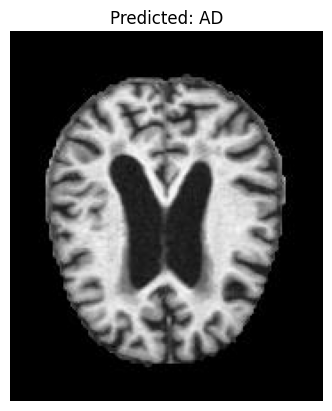

Prediction: AD


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

def predict_and_display(image_path, model, class_names):
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        _, pred = torch.max(outputs, 1)
        predicted_class = class_names[pred.item()]

    # Display image and prediction
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis("off")
    plt.show()

    return predicted_class

# Example usage
image_path = "/content/Dataset/test/AD_2574.png"  # replace with actual path
predicted_class = predict_and_display(image_path, model, train_dataset.classes)
print("Prediction:", predicted_class)


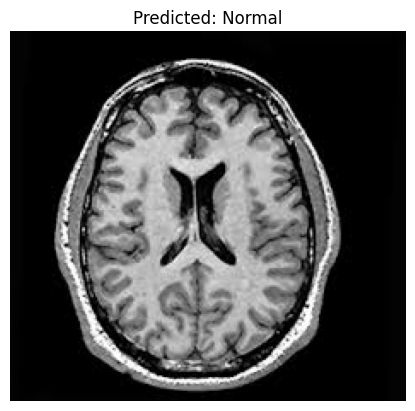

Prediction: Normal


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

def predict_and_display(image_path, model, class_names):
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        _, pred = torch.max(outputs, 1)
        predicted_class = class_names[pred.item()]

    # Display image and prediction
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis("off")
    plt.show()

    return predicted_class

# Example usage
image_path = "/content/Dataset/test/no437.jpg"  # replace with actual path
predicted_class = predict_and_display(image_path, model, train_dataset.classes)
print("Prediction:", predicted_class)


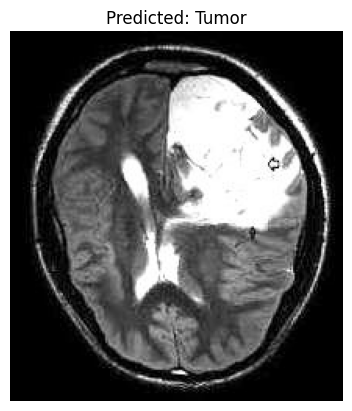

Prediction: Tumor


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

def predict_and_display(image_path, model, class_names):
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        _, pred = torch.max(outputs, 1)
        predicted_class = class_names[pred.item()]

    # Display image and prediction
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis("off")
    plt.show()

    return predicted_class

# Example usage
image_path = "/content/Dataset/test/y232.jpg"  # replace with actual path
predicted_class = predict_and_display(image_path, model, train_dataset.classes)
print("Prediction:", predicted_class)


The dataset used for disease classification includes the following categories:

**Alzheimer’s Disease (AD)**: A progressive neurological disorder characterized by memory loss, confusion, and cognitive decline. It is one of the most common causes of dementia in older adults.

**Cognitively Normal (CN)**: Individuals with no detectable cognitive impairments. These are healthy subjects used as control samples for comparison with affected patients.

Early Mild Cognitive Impairment (EMCI) **bold text**: An early stage of cognitive decline that may be a precursor to Alzheimer’s Disease. Patients show subtle but noticeable changes in memory and thinking abilities.

**Late Mild Cognitive Impairment (LMCI)**: A more advanced stage of MCI where symptoms are more significant but still do not meet the criteria for dementia. This stage has a higher risk of progressing to Alzheimer’s.

**Mild Cognitive Impairment (MCI):** A condition involving problems with memory, language, or other cognitive functions that are greater than normal age-related changes but not severe enough to interfere significantly with daily life.

**Normal**: These are subjects with no clinical symptoms or brain abnormalities. They serve as another baseline or control group for model training and evaluation.

**Tumor**: This category includes images showing the presence of brain tumors. These tumors can be benign or malignant and are typically identified via structural abnormalities in brain scans.

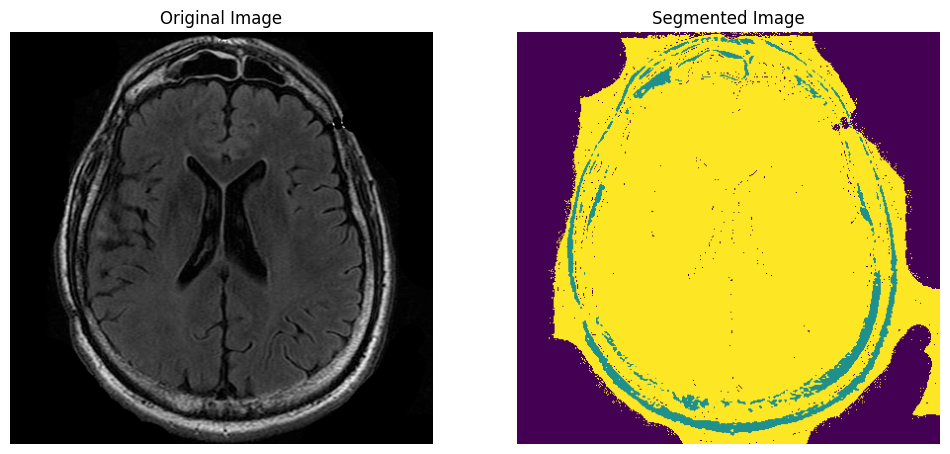

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from skimage import io, color
# Load the MRI image
image = io.imread('/content/Dataset/test/no432.jpg')
# Convert the image to grayscale
gray_image = color.rgb2gray(image)
# Reshape the image to 1D array
reshaped_image = gray_image.reshape(-1, 1)
# Define the number of clusters (brain tissues)
# Cluster 1: Gray Matter (responsible for information processing)
# Cluster 2: White Matter (connects different brain regions)
# Cluster 3: Cerebrospinal Fluid (protects the brain)
num_clusters = 3
# Fit Gaussian MixtMiMixtMi Rdxtureure Model
gmm = GaussianMixture(n_components=num_clusters, random_state=42)
gmm.fit(reshaped_image)
# Predict the labels (cluster assignments)
predicted_labels = gmm.predict(reshaped_image)# Reshape the predicted labels to original image shape
segmented_image = predicted_labels.reshape(gray_image.shape)
# Display original and segmented images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image, cmap='viridis')
plt.title('Segmented Image')
plt.axis('off')

plt.show()

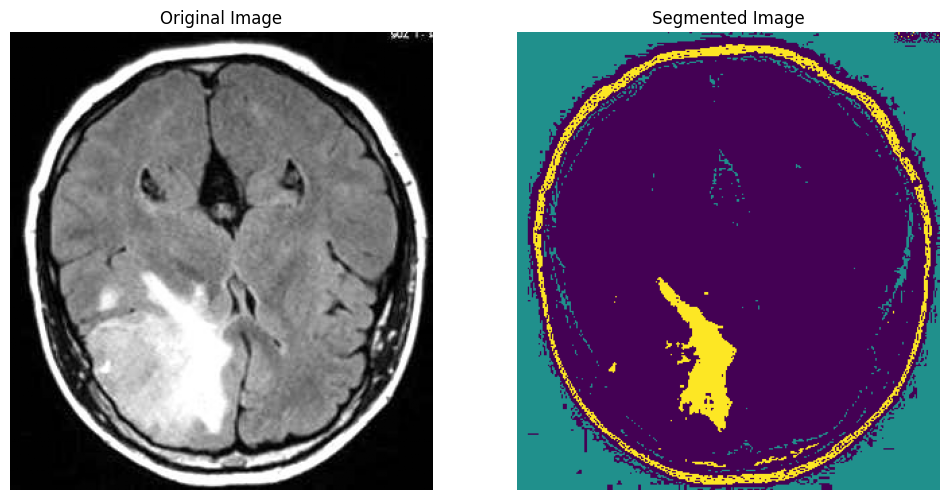

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from skimage import io, color
# Load the MRI image
image = io.imread('/content/Dataset/test/y226.jpg')
# Convert the image to grayscale
gray_image = color.rgb2gray(image)
# Reshape the image to 1D array
reshaped_image = gray_image.reshape(-1, 1)
# Define the number of clusters (brain tissues)
# Cluster 1: Gray Matter (responsible for information processing)
# Cluster 2: White Matter (connects different brain regions)
# Cluster 3: Cerebrospinal Fluid (protects the brain)
num_clusters = 3
# Fit Gaussian MixtMiMixtMi Rdxtureure Model
gmm = GaussianMixture(n_components=num_clusters, random_state=42)
gmm.fit(reshaped_image)
# Predict the labels (cluster assignments)
predicted_labels = gmm.predict(reshaped_image)# Reshape the predicted labels to original image shape
segmented_image = predicted_labels.reshape(gray_image.shape)
# Display original and segmented images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image, cmap='viridis')
plt.title('Segmented Image')
plt.axis('off')

plt.show()